### Practice Problem 5: RCH Industries' Differentiation

In [ ]:
from ortools.linear_solver import pywraplp
solver = pywraplp.Solver('factory', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [ ]:
stylish_p_to_xd_transportation_cost_coef = [[30,50], [23,66], [35,14], [70,12], [65,70]]
leisure_p_to_xd_transportation_cost_coef = [[33,55], [25,73], [39,15], [77,13], [12,14]]

stylish_xd_to_dc_transportation_cost_coef = [[12,25,22,40,41], [65,22,23,12,15]]
leisure_xd_to_dc_transportation_cost_coef = [[13,28,24,44,45], [72,24,25,13,17]]

stylish_demand = [130,45,70,100,5]
leisure_demand = [15,45,40,100,175]

max_stylish_demand = sum(stylish_demand)
max_leisure_demand = sum(leisure_demand)

plant_capacity_stylish = [150, 300, 90, 140, 220]
plant_capacity_leisure = [200, 300, 70,  30,  220]
plant_capacity_combined = [200, 300, 666, 666, 666]

# for question 2
plant_capacity_combined = [200, 300, 100, 150, 220]


n_plants = len(plant_capacity_combined)
n_xds = len(stylish_p_to_xd_transportation_cost_coef[0])
n_dcs = len(stylish_demand)

print(n_plants, 'plants')
print(n_xds, 'xds')
print(n_dcs, 'dcs')

In [ ]:
F_stylish_p_to_xd = {}
for p in range(n_plants):
    for xd in range(n_xds):
        F_stylish_p_to_xd[(p,xd)] = solver.IntVar(0, max_stylish_demand,
                                                 'f_stl_p{p}_xd{xd}'.format(p=p,xd=xd))
        
F_leisure_p_to_xd = {}
for p in range(n_plants):
    for xd in range(n_xds):
        F_leisure_p_to_xd[(p,xd)] = solver.IntVar(0, max_leisure_demand,
                                                 'f_lsr_p{p}_xd{xd}'.format(p=p,xd=xd))
        
F_stylish_xd_to_dc = {}
for xd in range(n_xds):
    for dc in range(n_dcs):
        F_stylish_xd_to_dc[(xd,dc)] = solver.IntVar(0, max_stylish_demand,
                                                 'f_stl_xd{xd}_dc{dc}'.format(dc=dc,xd=xd))
        
F_leisure_xd_to_dc = {}
for xd in range(n_xds):
    for dc in range(n_dcs):
        F_leisure_xd_to_dc[(xd,dc)] = solver.IntVar(0, max_leisure_demand,
                                                 'f_lsr_xd{xd}_dc{dc}'.format(dc=dc,xd=xd))


In [ ]:
### production costs 

# THERE AREN'T ANY


In [ ]:
#### transportation costs #####

## from Plants to XDs
# stylish 
stylish_p_to_xd_transportation_cost = [stylish_p_to_xd_transportation_cost_coef[p][xd]*\
                                       F_stylish_p_to_xd[(p, xd)]\
                                       for p in range(n_plants)\
                                       for xd in range(n_xds)]

# leisure
leisure_p_to_xd_transportation_cost = [leisure_p_to_xd_transportation_cost_coef[p][xd]*\
                                       F_leisure_p_to_xd[(p, xd)]\
                                       for p in range(n_plants)\
                                       for xd in range(n_xds)]

## from XDs to DCs
# stylish 
stylish_xd_to_dc_transportation_cost = [stylish_xd_to_dc_transportation_cost_coef[xd][dc]*\
                                       F_stylish_xd_to_dc[(xd, dc)]\
                                       for xd in range(n_xds)\
                                       for dc in range(n_dcs)]

# leisure
leisure_xd_to_dc_transportation_cost = [leisure_xd_to_dc_transportation_cost_coef[xd][dc]*\
                                       F_leisure_xd_to_dc[(xd, dc)]\
                                       for xd in range(n_xds)\
                                       for dc in range(n_dcs)]



In [ ]:
# capacity Constraints

# flow out of the factory cannot exceed capacity
# stylish
#for p in range(n_plants):
#    solver.Add(solver.Sum([F_stylish_p_to_xd[(p,xd)] for xd in range(n_xds)])\
#               <= plant_capacity_stylish[p])
# commented for Q2


# leisure
#for p in range(n_plants):
#    solver.Add(solver.Sum([F_leisure_p_to_xd[(p,xd)] for xd in range(n_xds)])\
#               <= plant_capacity_leisure[p])
# commented for Q2



# combined
for p in range(n_plants):
    solver.Add(solver.Sum([F_stylish_p_to_xd[(p,xd)]+F_leisure_p_to_xd[(p,xd)]\
                           for xd in range(n_xds)])\
               <= plant_capacity_combined[p])
    
    


In [ ]:
# Question 3 constraints
# least 10 units of each style needs to be produced in every factory
k = 10

# stylish
for p in range(n_plants):
    solver.Add(solver.Sum([F_stylish_p_to_xd[(p,xd)] for xd in range(n_xds)])\
               >= k)


# leisure
for p in range(n_plants):
    solver.Add(solver.Sum([F_leisure_p_to_xd[(p,xd)] for xd in range(n_xds)])\
               >= k)


In [ ]:
### Demand constraints ###

#the flow into DCs must match their demands 
#stylish 
for dc in range(n_dcs):
    solver.Add(solver.Sum([F_stylish_xd_to_dc[(xd, dc)]\
                for xd in range(n_xds)]) == stylish_demand[dc])
    
#leisure 
for dc in range(n_dcs):
    solver.Add(solver.Sum([F_leisure_xd_to_dc[(xd, dc)]\
                for xd in range(n_xds)]) == leisure_demand[dc])

In [ ]:
## balance of flow constraints 
# what comes in to a XD must leave the DC

#sty
for xd in range(n_xds):
    f_in = solver.Sum([F_stylish_p_to_xd[(p, xd)] for p in range(n_plants)])
    f_out = solver.Sum([F_stylish_xd_to_dc[(xd, dc)] for dc in range(n_dcs)])
    solver.Add(f_in == f_out)
    
#leisure
for xd in range(n_xds):
    f_in = solver.Sum([F_leisure_p_to_xd[(p, xd)] for p in range(n_plants)])
    f_out = solver.Sum([F_leisure_xd_to_dc[(xd, dc)] for dc in range(n_dcs)])
    solver.Add(f_in == f_out)

In [ ]:
### total costs ###

total_cost = solver.Sum([solver.Sum(stylish_p_to_xd_transportation_cost),
                         solver.Sum(leisure_p_to_xd_transportation_cost),
                         solver.Sum(stylish_xd_to_dc_transportation_cost),
                         solver.Sum(leisure_xd_to_dc_transportation_cost)])
                         

In [ ]:
### Ths solution finder
objective = solver.Minimize(total_cost)
solver.Solve()
print('done')


In [ ]:
for p in range(n_plants):
    for xd in range(n_xds):
        print('plant',p, '- xd', xd, 'style flow:', F_stylish_p_to_xd[(p, xd)].SolutionValue())
        

for xd in range(n_xds):
    for dc in range(n_dcs):
        print('xd',xd, '- dc', dc, 'style flow:', F_stylish_xd_to_dc[(xd, dc)].SolutionValue())

        
for p in range(n_plants):
    for xd in range(n_xds):
        print('plant',p, '- xd', xd, 'leisure flow:', F_leisure_p_to_xd[(p, xd)].SolutionValue())
        

for xd in range(n_xds):
    for dc in range(n_dcs):
        print('xd',xd, '- dc', dc, 'leisure flow:', F_leisure_xd_to_dc[(xd, dc)].SolutionValue())

print('\n')
print('total cost: ', solver.Objective().Value())


##  Problem 7

In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def inventory_fun(transit, alpha, beta):
    return(alpha * transit **beta)


i = [718, 791, 1349, 1544, 1908, 2166, 1276, 1564, 287, 1614, \
     1830, 1969, 1028, 2088, 1588, 1149, 1612, 1352, 1934, \
     292, 786, 1606, 980, 1415, 394, 2017, 987, 1292, 1950, \
     396, 681, 1781, 1870, 1237, 1412, 1853, 1186, 2051, \
     1387, 1827, 1147, 1573, 589, 1392, 580, 1736, 1166, \
     1950, 1750, 1969, 1022, 2279, 1386, 1623, 808, 2296, \
     934, 1759, 246, 341, 1831, 1791, 2234, 1769, 703, \
     874, 1864, 1755, 1363, 1961, 1992, 1897, 2169, 847, 1393, \
     1941, 905, 1906, 1512, 2042, 633, 891, 1654, 1171, 1281, \
     2350, 1195, 2138, 217, 1409, 2064, 1737, 543, 1920, 1907, \
     491, 1948, 1204, 246, 1182, 889, 1432, 1559, 695, 1115, \
     455, 1278, 1056, 863, 227, 1621, 2037, 1461]


t = [2318, 2136, 4232, 6097, 9820, 8883, 4398, 5637, 337, 5968, \
     7268, 9484, 3058, 8335, 5852, 4140, 6476, 4650, 6921, 146, \
     1814, 5765, 3396, 4999, 829, 8882, 2536, 5058, 8808, 757, \
     1718, 8757, 8755, 3963, 4985, 8082, 5070, 9677, 5417, 8103, \
     3343, 6090, 973, 4365, 874, 6402, 3734, 9180, 7218, 9911, 3186, \
     9896, 4418, 6866, 1972, 9888, 2154, 7078, 467, 482, 7991, 7694, \
     9562, 6534, 1379, 2791, 9645, 6928, 4393, 9163, 8033, 7655, \
     9889, 2633, 5130, 8133, 2760, 8833, 5456, 8473, 1477, 2516, \
     7507, 3655, 4066, 9726, 4547, 9211, 255, 5210, 9939, 6904, \
     1141, 7506, 9316, 817, 9896, 3517, 132, 3955, 2391, 5410, 5629, \
     2115, 3596, 782, 4537, 2855, 3225, 319, 6369, 8315, 4765]


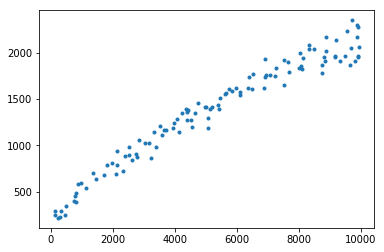

In [2]:
plt.plot(t, i, '.',
         label='fit:')
plt.show()

popt, pcov = curve_fit(inventory_fun, t, i)

In [3]:
popt

array([7.29470498, 0.61706041])

In [4]:
pcov

array([[ 8.18777876e-01, -1.27116153e-02],
       [-1.27116153e-02,  1.97835596e-04]])

In [7]:
inventory_fun(alpha=popt[0], beta=popt[1], transit=20000)

3288.5393810825403

In [6]:
inventory_fun(alpha=popt[0], beta=popt[1], transit=10000) + inventory_fun(alpha=popt[0], beta=popt[1], transit=10000)

4288.242644621963